In [1]:
import numpy as np
from sklearn.datasets import make_moons
import math
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib import cm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
N_SAMPLES = 1000
X_data, y_data_t = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
y_data = y_data_t.reshape(N_SAMPLES,1)
m = int(X_data.shape[0])
m_tr = int(math.ceil((90/100)*m))
m_cv = int(math.ceil((5/100)*m))
m_te = m - (m_tr + m_cv)
X_tr = np.zeros((m_tr,X_data.shape[1]))
y_tr_t = np.zeros((m_tr,1))
X_cv = np.zeros((m_cv,X_data.shape[1]))
y_cv_t = np.zeros((m_cv,1))
X_te = np.zeros((m_te,X_data.shape[1]))
y_te_t = np.zeros((m_te,1))
perm = np.random.permutation(m)
p = perm.reshape(m,1)
for i in range(0,m_tr):
  X_tr[i] = X_data[p[i]]
  y_tr_t[i] = y_data[p[i]]
for i in range(0,m_cv):
  X_cv[i] = X_data[p[i+m_tr]]
  y_cv_t[i] = y_data[p[i+m_tr]]
for i in range(0,m_te):
  X_te[i] = X_data[p[i+m_tr+m_cv]]
  y_te_t[i] = y_data[p[i+m_tr+m_cv]]
y_tr = y_tr_t.T
y_cv = y_cv_t.T
y_te = y_te_t.T

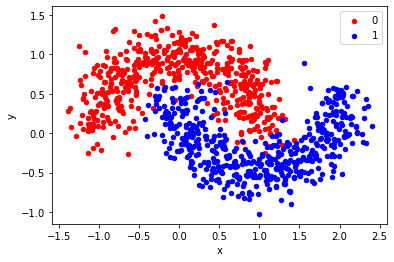

In [3]:
df = DataFrame(dict(x=X_data[:,0], y=X_data[:,1], label=y_data_t))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [4]:
class Activations:
  """
      Contains the activation functions and their gradients along with the variables 
      necessary for initializing the weights of the neural network.
      SubClasses:
        ActivationsForward
        ActivationsBackward
  """
  @staticmethod
  def relu(x):
    return np.maximum(0,x)
    
  @staticmethod
  def tanh(x):
    return np.tanh(x)
    
  @staticmethod
  def sigmoid(x):
    calc = 1 / (1 + np.exp(-x))
    return calc

  @staticmethod
  def relu_backward(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

  @staticmethod
  def tanh_backward(x):
    return (1 - np.square(np.tanh(x)))

  @staticmethod
  def sigmoid_backward(x):
    return (np.exp(-x)/np.square(1 + np.exp(-x)))

In [5]:
class Helpers:
  """
      Contains the helper functions for calculating Cost Function, predicting and
      accuracy of the network
      Methods:
        CostFunction
        Predictions
        Accuracy
  """
  @staticmethod
  def cost_function(y, A):
    cost = (-1/y.shape[1])*(np.sum(np.sum((y*np.log(A)) + ((1-y)*(np.log(1-A))))))
    return cost
  
  @staticmethod
  def predict(A,threshold=0.5):
    predictions = np.zeros((A.shape))
    for g in range(0,A.shape[1]):
      if A[:,g] >= threshold:
        predictions[:,g] = 1
    return predictions
  
  @staticmethod
  def evaluate(y, preds):
    accuracy = float(np.mean(preds==y,axis=1)*100)
    return accuracy
  
  @staticmethod
  def prec_rec(A,y):
    tp = 0
    fp = 0
    fn = 0
    for i in range(0,y.shape[1]):
      if ((A[0,i]==1)and(y[0,i]==1)):
        tp = tp+1
      if ((A[0,i]==1)and(y[0,i]==0)):
        fp = fp+1
      if (A[0,i]==0)and(y[0,i]==1):
        fn = fn+1
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = (2*prec*rec)/(prec+rec)
    return prec,rec,f1

In [6]:
class Dense:
  """
      This layer is used for implemetation of Fully Connected Neural Networks
      Methods:
        Parameters Initialization
        Forward Propagation
        Backward Propagation
  """
  def __init__(self,num_inputs,num_outputs,activation_fn,weights=None,bias=None,dZ=None,dW=None,db=None,dA=None):
    self.num_inputs = num_inputs
    self.num_outputs = num_outputs
    self.activation_fn = activation_fn
    self.dZ,self.dW,self.db,self.dA = dZ,dW,db,dA
    self.weights = weights
    self.bias = bias
    self.activ_dict = {"relu":[Activations.relu,Activations.relu_backward,2],"tanh":[Activations.tanh,Activations.tanh_backward,1],"sigmoid":[Activations.sigmoid,Activations.sigmoid_backward,1]}

  def initialize_params(self):
    self.weights = np.random.randn(self.num_outputs, self.num_inputs)*(np.sqrt(self.activ_dict[self.activation_fn][2]/self.num_inputs))
    self.bias = np.random.randn(self.num_outputs, 1)*0.01
    return self.weights,self.bias

  def get_params(self):
    return self.weights, self.bias
    
  def forw_prop(self,A_prev):
    self.outputs = np.dot(self.weights,A_prev) + self.bias
    self.activations = self.activ_dict[self.activation_fn][0](self.outputs)
    return self.outputs,self.activations

  def back_prop(self,dA_prev,A_prev):
    self.dZ = dA_prev*self.activ_dict[self.activation_fn][1](self.outputs)
    self.dW = np.dot(self.dZ,A_prev.T)
    self.db = np.sum(self.dZ,axis=1,keepdims = True)
    self.dA = np.dot(self.weights.T,self.dZ)
    return self.dZ,self.dW,self.db,self.dA

In [7]:
class Optimizers:
  """
      Contains the optimizers for the Neural Networks and for updating of parameters
      SubClasses:
        GradientDescent
        Adam
        Momentum
        StochasticGradientDescent
  """
  @staticmethod
  def gradient_descent(alpha,layers_arr,V_dict,S_dict,t):
    for layers in layers_arr:
      layers.weights -= (alpha*layers.dW)
      layers.bias -= (alpha*layers.db)

  @staticmethod
  def gd_mom(alpha,layers_arr,V_dict,S_dict,t):
    beta1 = 0.9
    for h in range(1,len(layers_arr)):
      V_dict["Vdw" + str(h)] = (beta1*V_dict["Vdw" + str(h)]) + ((1-beta1)*layers_arr[h-1].dW)
      V_dict["Vdb" + str(h)] = (beta1*V_dict["Vdb" + str(h)]) + ((1-beta1)*layers_arr[h-1].db)
    for g in range(1,len(layers_arr)):
      layers_arr[g-1].weights -= (alpha*V_dict["Vdw" + str(g)])
      layers_arr[g-1].bias -= (alpha*V_dict["Vdb" + str(g)])
  
  @staticmethod
  def rms_prop(alpha,layers_arr,V_dict,S_dict,t):
    beta2 = 0.999
    epsilon = 1e-8
    for h in range(1,len(layers_arr)):
      S_dict["Sdw" + str(h)] = (beta2*S_dict["Sdw" + str(h)]) + ((1-beta2)*np.square(layers_arr[h-1].dW))
      S_dict["Sdb" + str(h)] = (beta2*S_dict["Sdb" + str(h)]) + ((1-beta2)*np.square(layers_arr[h-1].db))
    for g in range(1,len(layers_arr)):
      layers_arr[g-1].weights -= ((alpha*layers_arr[g-1].dW)/(np.sqrt(S_dict["Sdw" + str(g)]) + epsilon))
      layers_arr[g-1].bias -= ((alpha*layers_arr[g-1].db)/(np.sqrt(S_dict["Sdb" + str(g)]) + epsilon))

  @staticmethod
  def adam(alpha,layers_arr,V_dict,S_dict,t):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    S_dict_corr = {}
    V_dict_corr = {}
    for h in range(1,len(layers_arr)):
      V_dict["Vdw" + str(h)] = (beta1*V_dict["Vdw" + str(h)]) + ((1-beta1)*layers_arr[h-1].dW)
      V_dict["Vdb" + str(h)] = (beta1*V_dict["Vdb" + str(h)]) + ((1-beta1)*layers_arr[h-1].db)
    for u in range(1,len(layers_arr)):
      S_dict["Sdw" + str(u)] = (beta2*S_dict["Sdw" + str(u)]) + ((1-beta2)*np.square(layers_arr[u-1].dW))
      S_dict["Sdb" + str(u)] = (beta2*S_dict["Sdb" + str(u)]) + ((1-beta2)*np.square(layers_arr[u-1].db))
    for n in range(1,len(layers_arr)):
      S_dict_corr["Sdw" + str(n)] = S_dict["Sdw" + str(n)]/(1 - np.power(beta2,t))
      S_dict_corr["Sdb" + str(n)] = S_dict["Sdb" + str(n)]/(1 - np.power(beta2,t))
      V_dict_corr["Vdw" + str(n)] = V_dict["Vdw" + str(n)]/(1 - np.power(beta1,t))
      V_dict_corr["Vdb" + str(n)] = V_dict["Vdb" + str(n)]/(1 - np.power(beta1,t))
    for g in range(1,len(layers_arr)):
      layers_arr[g-1].weights -= ((alpha*V_dict_corr["Vdw" + str(g)])/(np.sqrt(S_dict_corr["Sdw" + str(g)]) + epsilon))
      layers_arr[g-1].bias -= ((alpha*V_dict_corr["Vdb" + str(g)])/(np.sqrt(S_dict_corr["Sdb" + str(g)]) + epsilon))

In [8]:
class Model:
  """
      Binds all the other classes together and contains methods for adding layers,
      training the network and testing the network
      Methods:
        Add
        Fit
        Test
  """ 
  def __init__(self,X_tr,y_tr,X_te,y_te,X_cv,y_cv):
    self.X_tr, self.y_tr, self.m_tr = X_tr, y_tr, X_tr.shape[0] 
    self.X_te, self.y_te, self.m_te = X_te, y_te, X_te.shape[0]
    self.X_cv, self.y_cv, self.m_cv = X_cv, y_cv, X_cv.shape[0]
    self.layer_names = []
    self.activations_cache = None
    self.params = None

  def add(self,layer_name,num_inputs,num_outputs,act_fn):
    layer_name = Dense(num_inputs,num_outputs,act_fn)
    Dense.initialize_params(layer_name)
    self.layer_names.append(layer_name)
  
  def reset(self):
    self.layer_names = []
    return self.layer_names

  def params_dict(self,print_params):
    self.params = {}
    num = 1
    for layer in self.layer_names:
      self.params["W" + str(num)],self.params["b" + str(num)] = Dense.get_params(layer)
      num += 1
    if print_params is True:
      print(self.params)
      return self.params
    else:
      return self.params

  def forward_prop(self,X):
    self.activations_cache = []
    temp_A = X.T
    for layer in self.layer_names:
      _,temp_A = Dense.forw_prop(layer,temp_A)
      self.activations_cache.append(temp_A)
    return self.activations_cache

  def backward_prop(self,y):
    temp_dA = (-1/y.shape[1])*((y/self.activations_cache[-1]) - ((1-y)/(1-self.activations_cache[-1])))
    l = len(self.layer_names)-2
    for layer in reversed(self.layer_names):
      _,layer.dW,layer.db,temp_dA = Dense.back_prop(layer,temp_dA,self.activations_cache[l])
      l -= 1
  
  def fit(self,X,y,alpha,num_iter,optim,print_cost=True,callback=None):
    params = self.params_dict(print_params=False)
    V_dict = {}
    S_dict = {}
    for k in range(1,len(self.layer_names)):
      V_dict["Vdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
      V_dict["Vdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
      S_dict["Sdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
      S_dict["Sdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
    optim_dict = {"BGD":[Optimizers.gradient_descent,None,None,0],
                  "Momentum":[Optimizers.gd_mom,V_dict,None,0],
                  "RMSprop":[Optimizers.rms_prop,None,S_dict,0],
                  "Adam":[Optimizers.adam,V_dict,S_dict,0]}
    for i in range(1,num_iter+1):
      activations_cache = self.forward_prop(X)
      cost = Helpers.cost_function(y,activations_cache[-1])
      self.backward_prop(y)
      optim_dict[optim][0](alpha,self.layer_names,optim_dict[optim][1],optim_dict[optim][2],optim_dict[optim][3]+i)
      preds = Helpers.predict(activations_cache[-1])
      accu_tr = Helpers.evaluate(y,preds)
      if ((i%1==0) and print_cost==True):
        print("Cost after iteration " + str(i) + " is: " + str(np.round(cost,6)) + "-----" + "Training accuracy: " + str(np.round(accu_tr,3)))
      if(i % 1 == 0):
        if(callback is not None):
          callback(i, params)

  def test(self,X,y,print_values=True):
    act_te = self.forward_prop(X)
    predictions_te = Helpers.predict(act_te[-1])
    accu_te = Helpers.evaluate(y,predictions_te)
    prec_te,rec_te,f1_te = Helpers.prec_rec(predictions_te,y)
    if print_values is True:
      print("TEST RESULTS: ")
      print("Testing accuracy = " + str(accu_te))
      print("Precision: " + str(prec_te))
      print("Recall: " + str(rec_te))
      print("F1 score: " + str(f1_te))
      print('\n')
      print('\n')
    return accu_te,prec_te,rec_te,f1_te

In [9]:
model = Model(X_tr,y_tr,X_te,y_te,X_cv,y_cv)

In [13]:
model.reset()
model.add("dense1",2,100,"relu")
model.add("dense2",100,60,"relu")
model.add("dense3",60,30,"relu")
model.add("dense4",30,15,"tanh")
model.add("dense5",15,1,"sigmoid")

In [14]:
model.fit(X_tr,y_tr,0.05,50,"Adam")

Cost after iteration 1 is: 0.800922-----Training accuracy: 41.0
Cost after iteration 2 is: 0.458194-----Training accuracy: 79.333
Cost after iteration 3 is: 0.787995-----Training accuracy: 51.222
Cost after iteration 4 is: 0.53043-----Training accuracy: 64.111
Cost after iteration 5 is: 0.365121-----Training accuracy: 85.889
Cost after iteration 6 is: 0.383054-----Training accuracy: 83.889
Cost after iteration 7 is: 0.369141-----Training accuracy: 84.556
Cost after iteration 8 is: 0.34124-----Training accuracy: 86.333
Cost after iteration 9 is: 0.320495-----Training accuracy: 87.667
Cost after iteration 10 is: 0.326845-----Training accuracy: 87.111
Cost after iteration 11 is: 0.318054-----Training accuracy: 87.333
Cost after iteration 12 is: 0.311648-----Training accuracy: 87.222
Cost after iteration 13 is: 0.302587-----Training accuracy: 87.667
Cost after iteration 14 is: 0.284438-----Training accuracy: 88.0
Cost after iteration 15 is: 0.273974-----Training accuracy: 88.222
Cost after

In [15]:
model.test(X_te,y_te)

TEST RESULTS: 
Testing accuracy = 100.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0






(100.0, 1.0, 1.0, 1.0)

In [18]:
sns.set_style("whitegrid")
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
OUTPUT_DIR = "/content/drive/My Drive/Colab Notebooks/nn_visuals/oop_adam"
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2,-1)
XX, YY = grid
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
import os
init_params = model.params_dict(print_params=False)
def callback_numpy_plot(index, init_params):
    plot_title = "Iteration {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//1)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    act = model.forward_prop(np.transpose(grid_2d))
    prediction_probs = act[-1]
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_te, y_te, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [22]:
model.reset()
model.add("dense1",2,100,"relu")
model.add("dense2",100,60,"relu")
model.add("dense3",60,30,"relu")
model.add("dense4",30,15,"tanh")
model.add("dense5",15,1,"sigmoid")
model.fit(X_tr,y_tr,0.05,100,"Adam",print_cost=False,callback=callback_numpy_plot)

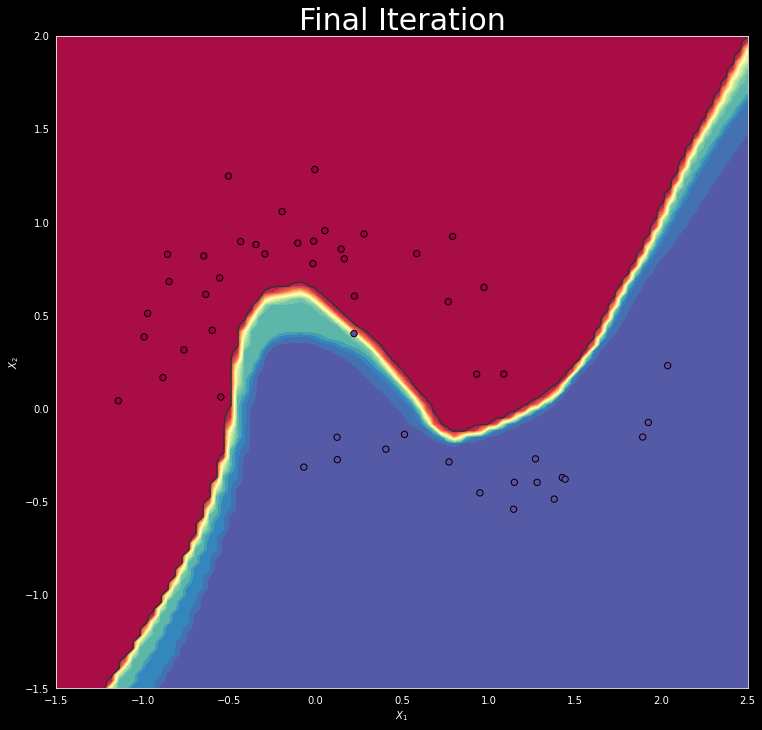

In [21]:
act = model.forward_prop(np.transpose(grid_2d))
prediction_probs_np = act[-1]
prediction_probs_np = prediction_probs_np.reshape(prediction_probs_np.shape[1], 1)
make_plot(X_te, y_te, "Final Iteration", file_name=None, XX=XX, YY=YY, preds=prediction_probs_np, dark=True)